# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 11.3KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

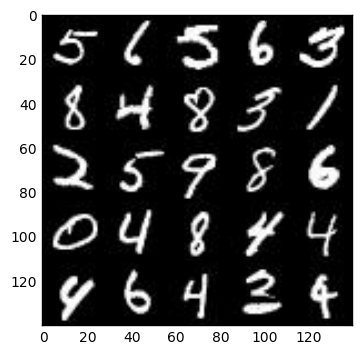

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

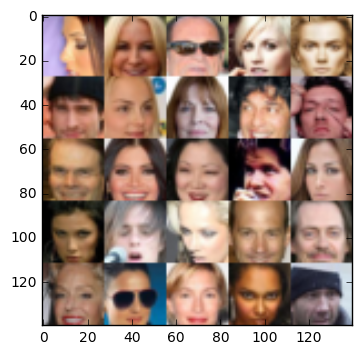

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2  #leaky Relu, leak factor 
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
 
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2     #leaky Relu, leak factor 
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = tf.maximum(alpha * x1, x1)
             
        x2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * x2, x2)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 32
    
    # Get image shape
    image_width, image_height, num_channels = data_shape[1:]
    
    # Build the model now:
    input_real, input_z, LR = model_inputs(image_width, image_height, num_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, num_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    _ = show_generator_output(sess, n_images, input_z, num_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3613... Generator Loss: 2.0198
Epoch 1/2... Discriminator Loss: 2.7542... Generator Loss: 0.1342
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.4454
Epoch 1/2... Discriminator Loss: 0.2098... Generator Loss: 2.7479
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 4.7846
Epoch 1/2... Discriminator Loss: 0.4179... Generator Loss: 1.6301
Epoch 1/2... Discriminator Loss: 0.6815... Generator Loss: 1.6146
Epoch 1/2... Discriminator Loss: 0.8813... Generator Loss: 2.5446
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 3.4937


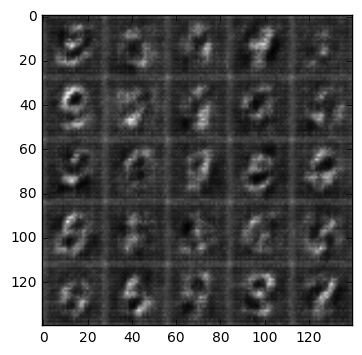

Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 2.7779
Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 0.3055
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 0.6671... Generator Loss: 1.1462
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 2.2503
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 1.8195
Epoch 1/2... Discriminator Loss: 0.5942... Generator Loss: 1.9285
Epoch 1/2... Discriminator Loss: 0.6274... Generator Loss: 1.7797


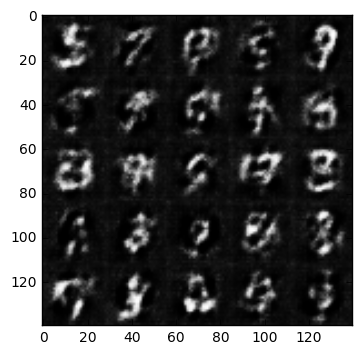

Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 1.4594
Epoch 1/2... Discriminator Loss: 0.5018... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 0.6082... Generator Loss: 1.0961
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 3.1199
Epoch 1/2... Discriminator Loss: 0.5697... Generator Loss: 1.2009
Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 2.5285
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 1.3953
Epoch 1/2... Discriminator Loss: 0.6142... Generator Loss: 1.0783
Epoch 1/2... Discriminator Loss: 0.4647... Generator Loss: 2.1170
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 1.8348


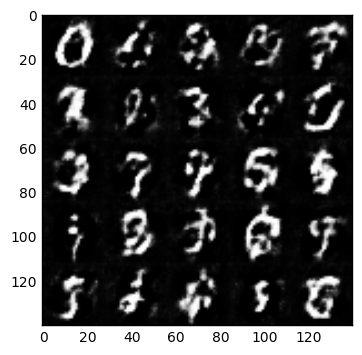

Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 1.0547
Epoch 1/2... Discriminator Loss: 0.3633... Generator Loss: 1.9518
Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 0.3044... Generator Loss: 2.1517
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 3.6158
Epoch 1/2... Discriminator Loss: 0.5063... Generator Loss: 1.4051
Epoch 1/2... Discriminator Loss: 0.4238... Generator Loss: 2.0768
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 5.1118
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 1.0591
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 1.0252


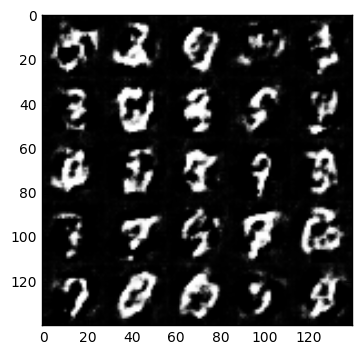

Epoch 1/2... Discriminator Loss: 0.3423... Generator Loss: 2.1573
Epoch 1/2... Discriminator Loss: 0.3736... Generator Loss: 2.2175
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 0.8891... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 0.4479... Generator Loss: 1.7280
Epoch 1/2... Discriminator Loss: 0.3206... Generator Loss: 2.1767
Epoch 1/2... Discriminator Loss: 0.4616... Generator Loss: 1.9364
Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 2.8511
Epoch 1/2... Discriminator Loss: 0.4522... Generator Loss: 1.7297
Epoch 1/2... Discriminator Loss: 0.5471... Generator Loss: 2.6144


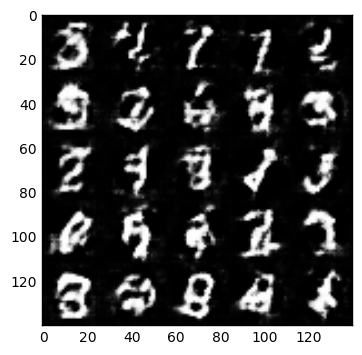

Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.0700
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 0.4396... Generator Loss: 2.1885
Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 1.8232
Epoch 1/2... Discriminator Loss: 0.4550... Generator Loss: 2.2832
Epoch 1/2... Discriminator Loss: 0.4914... Generator Loss: 2.2988
Epoch 1/2... Discriminator Loss: 0.5370... Generator Loss: 1.4232
Epoch 1/2... Discriminator Loss: 0.5095... Generator Loss: 1.6102
Epoch 1/2... Discriminator Loss: 0.3571... Generator Loss: 1.7528
Epoch 1/2... Discriminator Loss: 0.3762... Generator Loss: 1.6248


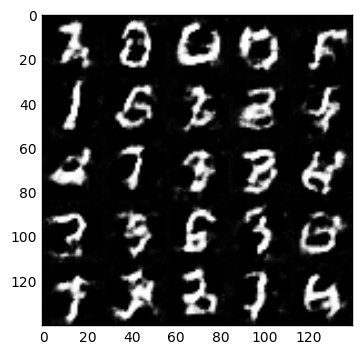

Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.5323... Generator Loss: 1.4171
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 2.6513
Epoch 1/2... Discriminator Loss: 0.4263... Generator Loss: 2.1803
Epoch 1/2... Discriminator Loss: 1.8764... Generator Loss: 0.2570
Epoch 1/2... Discriminator Loss: 0.6100... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 0.4364... Generator Loss: 1.7245
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 1.3732


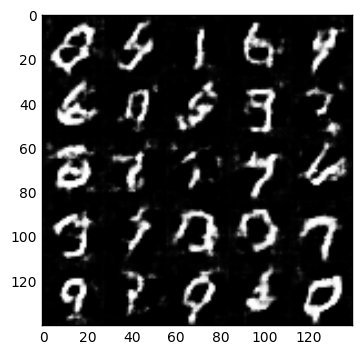

Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 1.5627
Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 1.0590
Epoch 1/2... Discriminator Loss: 0.5025... Generator Loss: 1.4679
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 3.5584
Epoch 1/2... Discriminator Loss: 0.5298... Generator Loss: 2.3941
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 1.9205
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 0.7021... Generator Loss: 2.7782
Epoch 1/2... Discriminator Loss: 0.4647... Generator Loss: 1.4801
Epoch 1/2... Discriminator Loss: 1.5997... Generator Loss: 0.3193


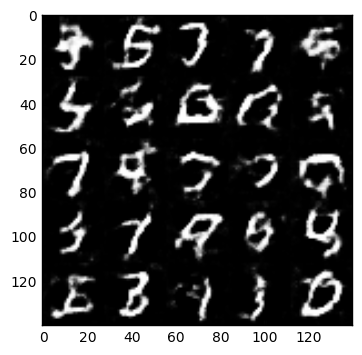

Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.4659
Epoch 1/2... Discriminator Loss: 0.3981... Generator Loss: 1.6238
Epoch 1/2... Discriminator Loss: 0.6578... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 2.0088
Epoch 1/2... Discriminator Loss: 0.6075... Generator Loss: 1.1031
Epoch 1/2... Discriminator Loss: 0.5321... Generator Loss: 1.3354
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 0.5238... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 1.0800


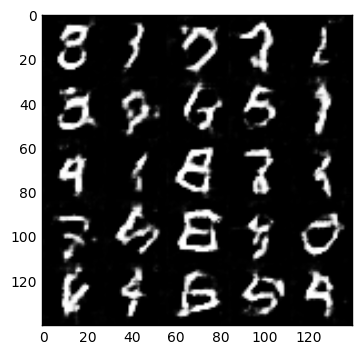

Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 1.0489
Epoch 1/2... Discriminator Loss: 0.5020... Generator Loss: 1.4232
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 1.5203
Epoch 2/2... Discriminator Loss: 0.3406... Generator Loss: 1.7513
Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 1.7074
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 1.5008
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 5.7609... Generator Loss: 8.4895


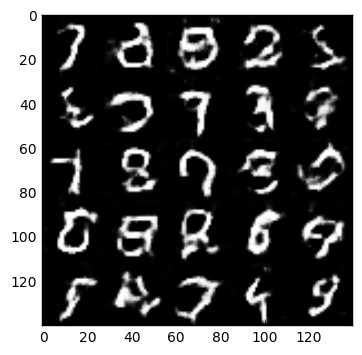

Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 1.5906
Epoch 2/2... Discriminator Loss: 0.4937... Generator Loss: 1.5640
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 1.2385
Epoch 2/2... Discriminator Loss: 0.5861... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 1.3660
Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 1.3909
Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 2.4024
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 0.5690... Generator Loss: 1.2147


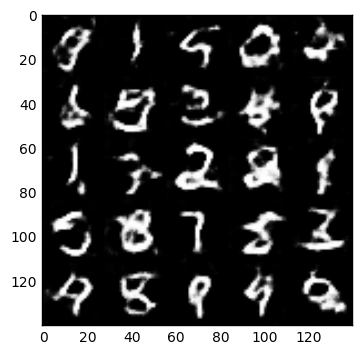

Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 1.4558
Epoch 2/2... Discriminator Loss: 0.5092... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 0.3598... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 0.5207... Generator Loss: 1.3727
Epoch 2/2... Discriminator Loss: 0.3711... Generator Loss: 2.5847
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 4.7288
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 0.4620... Generator Loss: 1.4002


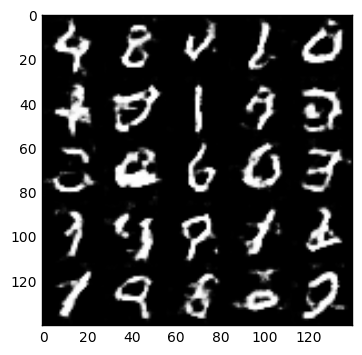

Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 1.3425
Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 1.3978
Epoch 2/2... Discriminator Loss: 0.5172... Generator Loss: 1.2129
Epoch 2/2... Discriminator Loss: 0.3288... Generator Loss: 1.6790
Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 1.0689
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 1.2944
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 0.4573... Generator Loss: 1.4901
Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 1.9524
Epoch 2/2... Discriminator Loss: 0.6025... Generator Loss: 1.1251


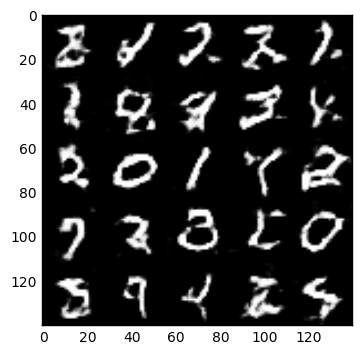

Epoch 2/2... Discriminator Loss: 0.3960... Generator Loss: 1.5197
Epoch 2/2... Discriminator Loss: 0.4310... Generator Loss: 1.4033
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 1.1806
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 1.1530
Epoch 2/2... Discriminator Loss: 0.6131... Generator Loss: 1.1233
Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 1.5062
Epoch 2/2... Discriminator Loss: 0.5001... Generator Loss: 1.2690
Epoch 2/2... Discriminator Loss: 0.2733... Generator Loss: 2.3114
Epoch 2/2... Discriminator Loss: 0.3116... Generator Loss: 1.8868


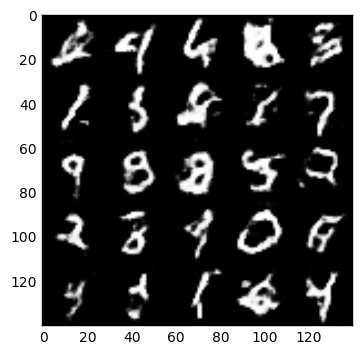

Epoch 2/2... Discriminator Loss: 0.4215... Generator Loss: 1.3221
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 1.7314
Epoch 2/2... Discriminator Loss: 0.4848... Generator Loss: 1.2665
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.2678
Epoch 2/2... Discriminator Loss: 0.2768... Generator Loss: 2.0761
Epoch 2/2... Discriminator Loss: 0.3604... Generator Loss: 1.5742
Epoch 2/2... Discriminator Loss: 0.2899... Generator Loss: 2.0197
Epoch 2/2... Discriminator Loss: 0.2551... Generator Loss: 1.9787
Epoch 2/2... Discriminator Loss: 2.0473... Generator Loss: 3.6682
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 0.9808


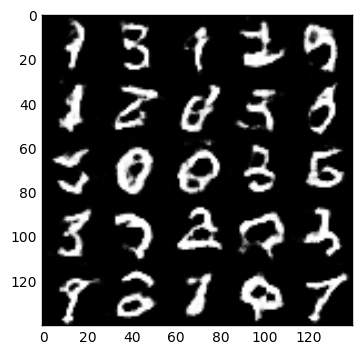

Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 2.8382
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 0.4998... Generator Loss: 1.6098
Epoch 2/2... Discriminator Loss: 1.6883... Generator Loss: 4.4488
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 0.9650
Epoch 2/2... Discriminator Loss: 0.6173... Generator Loss: 1.1939
Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 1.5982
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.7772


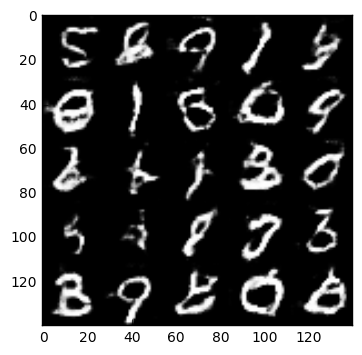

Epoch 2/2... Discriminator Loss: 0.5409... Generator Loss: 1.0690
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 0.4289... Generator Loss: 1.3659
Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 0.5392... Generator Loss: 1.1155
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 1.2366
Epoch 2/2... Discriminator Loss: 0.4212... Generator Loss: 1.4051
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 1.2117


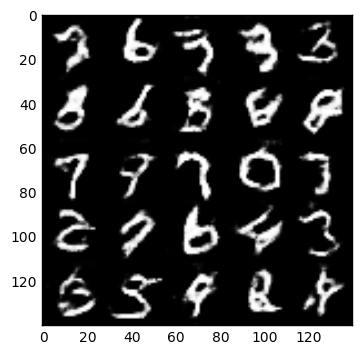

Epoch 2/2... Discriminator Loss: 0.4600... Generator Loss: 1.3086
Epoch 2/2... Discriminator Loss: 0.2000... Generator Loss: 2.6314
Epoch 2/2... Discriminator Loss: 0.3497... Generator Loss: 1.6200
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 0.4735... Generator Loss: 1.2952
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 1.1424
Epoch 2/2... Discriminator Loss: 0.3404... Generator Loss: 1.5523
Epoch 2/2... Discriminator Loss: 0.3924... Generator Loss: 1.5082
Epoch 2/2... Discriminator Loss: 0.3767... Generator Loss: 1.6701
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 1.4069


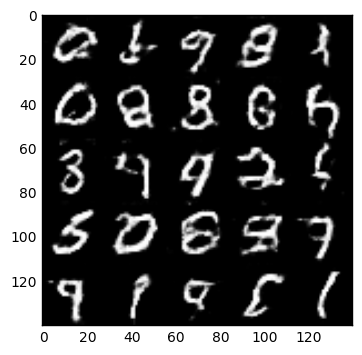

Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 0.2206... Generator Loss: 2.2230
Epoch 2/2... Discriminator Loss: 1.5725... Generator Loss: 0.3633
Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 2.6852
Epoch 2/2... Discriminator Loss: 0.9518... Generator Loss: 3.1655
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 0.9165


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 1.6843
Epoch 1/1... Discriminator Loss: 0.2309... Generator Loss: 2.3031
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 2.4628
Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 2.9653
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 2.9048
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 3.5336
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 3.8149
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.4097


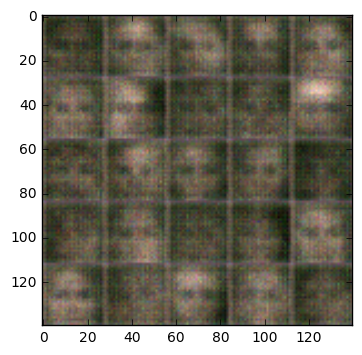

Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.9808
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.1777
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 1.8343
Epoch 1/1... Discriminator Loss: 0.5232... Generator Loss: 1.6394


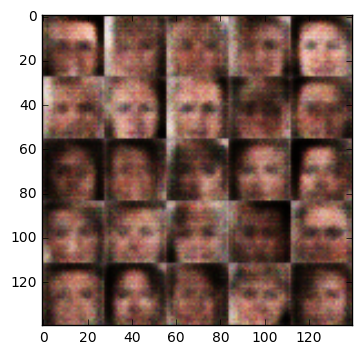

Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 2.0096
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 1.3799
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.6307
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 2.3252


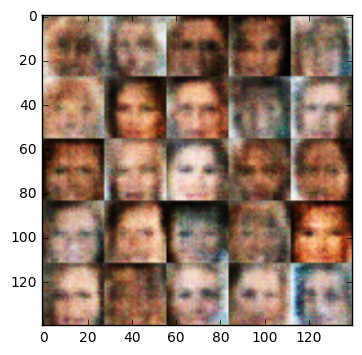

Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 1.5455
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 2.1477
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 1.6605
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 2.0652
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 1.3533


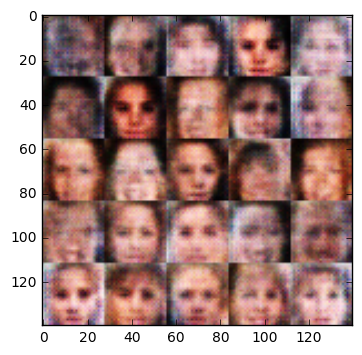

Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 1.8717
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 2.0597
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 1.5896
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 2.3340


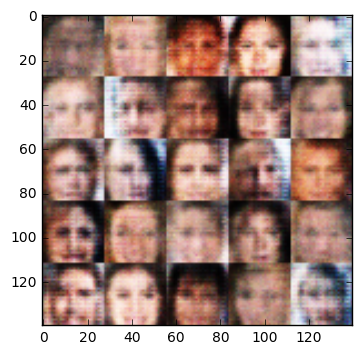

Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.3380


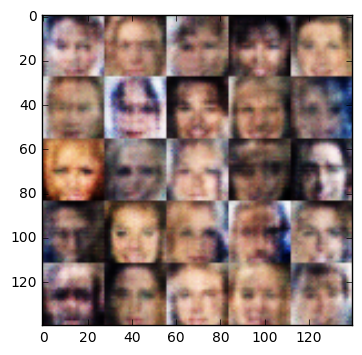

Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 1.4193
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.6215


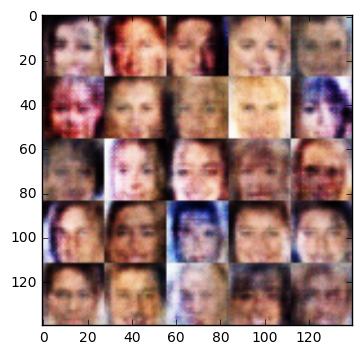

Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.0639


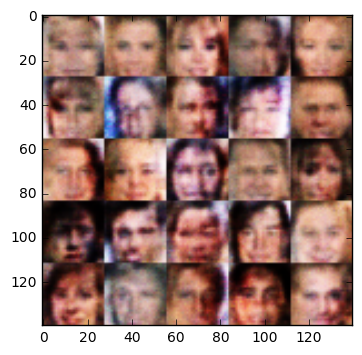

Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.6033
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 0.8660


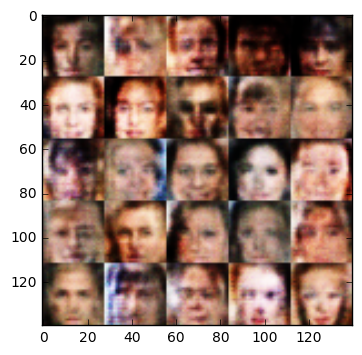

Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 2.4931
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 0.9553


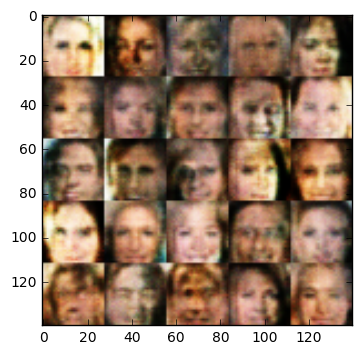

Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.6134
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.0664


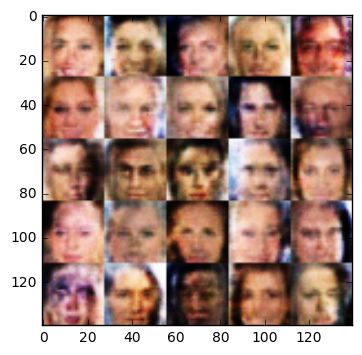

Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.0380


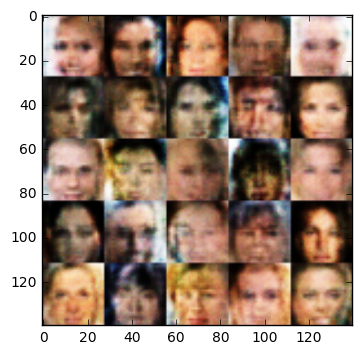

Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 0.9698


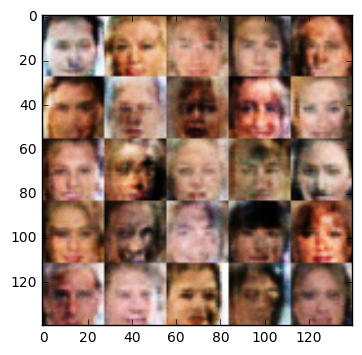

Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.5520
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.7502
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.4049


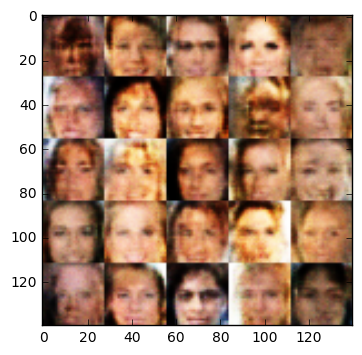

Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.3780
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.7340
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.2611


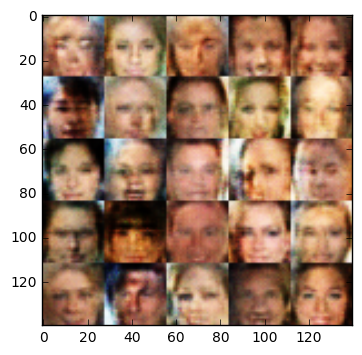

Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.2365


In [16]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.